# Flujo de trabajo geoespacial abierto para Deslizamientos

In [70]:
#1.Instalación de librerias
! pip install rasterio
! pip install earthpy
! pip install numpy
! pip install matplotlib

## Metodología

![Mi gráfico](metodologia.png)

In [71]:
#2. Importar librerias
import geopandas
import rasterio as rio
import matplotlib.pyplot as plt
import earthpy.plot as ep
import numpy as np
from pathlib import Path
from rasterio.mask import mask
import matplotlib.colors as mcolors

## DISEÑO DE LA FUNCIÓN

In [157]:
# Ajustamos la línea de escritura para final de susceptibilidad,
# de modo que usemos directamente la matriz 2D sin expandir dimensiones.

import os
import numpy as np
import rasterio as rio
from rasterio.mask import mask
from rasterio.warp import reproject, Resampling
import geopandas as gpd

# 3. Crear la función.

"""
La función tendrá 9 accesos: diccionario de bandas espectrales, rasters de entrada (pendiente, curvatura de perfil, índice TWI, cobertura de suelo, tipo de suelo),
área de estudio (shape o geojson), la ruta de los archivos de salida) 

"""

def susceptibilidad(
    band_paths,
    raster_pendiente_path,
    raster_curvatura_path,
    raster_twi_path,
    raster_cobertura_path,
    raster_tipo_path,
    area_estudio,
    carpeta_salida,
    pesos
):
    
    """
    La función susceptibilidad tendrá la siguiente línea:

    3.1. Preparar carpeta de salida.
    3.2. Leer polígono de área de estudio.
    3.3. Calcula índices espectrales (NDVI, NDWI, BSI).
    3.4. Recorta cada ráster al área de estudio.
    3.5. Reclasifica cada ráster recortado en clases 1–5.
    3.6. Reproyecta y combina las capas reclasificadas en un ráster continuo de susceptibilidad.
    3.7. Recorta el ráster final de susceptibilidad y reclasificarlo (nuevamente con nodata = -9999).
    3.8. Guarda todos los productos intermedios y finales en 'carpeta_salida'.
    3.9. Representación de mapas generados
    """

    # 3.1. Carpeta de salida
    os.makedirs(carpeta_salida, exist_ok=True)

    # 3.2. Leer polígono de área de estudio
    extension = os.path.splitext(area_estudio)[1].lower()
    # 3.2.1. Comprueba si el archivo del polígono de estudio es formato shp o geojson
    if extension not in [".shp", ".geojson", ".json"]:
        raise ValueError(f"El archivo de área de estudio debe ser un Shapefile (.shp) o GeoJSON (.geojson/.json), no '{extension}'")

    # 3.2.2. GeoPandas detecta automáticamente si es GeoJSON o Shapefile
    gdf_area = gpd.read_file(area_estudio)

    # 3.2.3. Extraemos las geometrías para pasarlas luego a rasterio.mask
    geometries = [feature["geometry"] 
              for feature in gdf_area.__geo_interface__["features"]]

   
    # Adicional1 - Función para recortar y asignar nodata=-9999 a los datos fuera del polígono
    def recortar_raster_con_nodata(ruta_raster, geometries, output_ruta, nodata_val=-9999):
        
        with rio.open(ruta_raster) as src:
            # Reproyectar geometrías si CRS difiere
            if src.crs != gdf_area.crs:
                geometries_proj = [feature["geometry"] for feature in gdf_area.to_crs(src.crs).__geo_interface__["features"]]
            else:
                geometries_proj = geometries

            # filled=False para obtener mascaras sin rellenar
            out_image, out_transform = mask(src, geometries_proj, crop=True, filled=False)
            # out_image es MaskedArray: out_image.data + out_image.mask
            arr_data = out_image.data
            arr_mask = out_image.mask

            # Crear array final substituyendo los píxeles enmascarados por nodata_val
            arr_filled = arr_data.copy()
            arr_filled[arr_mask] = nodata_val

            # Ajustar metadatos
            meta = src.profile.copy()
            meta.update({
                "height": arr_filled.shape[1],
                "width":  arr_filled.shape[2],
                "transform": out_transform,
                "nodata": nodata_val
            })

            os.makedirs(os.path.dirname(output_ruta), exist_ok=True)
            with rio.open(output_ruta, "w", **meta) as dst:
                dst.write(arr_filled)

            return output_ruta, arr_filled, meta

    # 3.3. Cálculo de índices de vegetación
    # 3.3.1. Funciones para calcular índices (sin recorte)
    # 3.3.1.1. NDVI
    def calcular_ndvi(ruta_red, ruta_nir):
        with rio.open(ruta_red) as src_r, rio.open(ruta_nir) as src_n:
            red = src_r.read(1).astype('float32')
            nir = src_n.read(1).astype('float32')
            ndvi = np.where((nir + red) == 0, 0, (nir - red) / (nir + red))
            meta = src_r.profile.copy()
            meta.update({"dtype": "float32", "count": 1, "nodata": None})
            return ndvi, meta

    # 3.3.1.2. NDWI
    def calcular_ndwi(ruta_verde, ruta_nir):
        with rio.open(ruta_verde) as src_v, rio.open(ruta_nir) as src_n:
            verde = src_v.read(1).astype('float32')
            nir   = src_n.read(1).astype('float32')
            ndwi  = np.where((verde + nir) == 0, 0, (verde - nir) / (verde + nir))
            meta  = src_v.profile.copy()
            meta.update({"dtype": "float32", "count": 1, "nodata": None})
            return ndwi, meta

    # 3.3.1.3. BSI
    def calcular_bsi(ruta_red, ruta_swir):
        ruta_blue = band_paths.get('Blue', None)
        if ruta_blue is None:           # Condicionante para la banda azul"
            raise ValueError("Para BSI necesitas 'Blue' en band_paths.")
        if ruta_swir is None:           # Condicionante para la banda SWIR"
            raise ValueError("Para BSI necesitas 'Blue' en band_paths.")
        with rio.open(ruta_red) as src_r, rio.open(ruta_swir) as src_s, rio.open(ruta_blue) as src_b:
            red  = src_r.read(1).astype('float32')
            swir = src_s.read(1).astype('float32')
            blue = src_b.read(1).astype('float32')
            with rio.open(band_paths['NIR']) as src_n:
                nir = src_n.read(1).astype('float32')
            bsi   = np.where(((red + swir) + (nir + blue)) == 0, 0, ((red + swir) - (nir + blue)) / ((red + swir) + (nir + blue)))
            meta  = src_r.profile.copy()
            meta.update({"dtype": "float32", "count": 1, "nodata": None})
            return bsi, meta

    # 3.3.2. Recortar índices y guardar temporalmente
    rutas_indices_recortados = {}         # Diccionario con índices recortados

    # 3.3.2.1. NDVI
    ndvi_arr, ndvi_meta = calcular_ndvi(band_paths['Red'], band_paths['NIR'])
    tmp_ndvi = os.path.join(carpeta_salida, "NDVI_temp.tif")
    with rio.open(tmp_ndvi, "w", **ndvi_meta) as dst:
        dst.write(ndvi_arr, 1)
    ruta_ndvi_rec, _, _ = recortar_raster_con_nodata(tmp_ndvi, geometries, os.path.join(carpeta_salida, "NDVI_recortado.tif"))
    rutas_indices_recortados['ndvi'] = ruta_ndvi_rec
    os.remove(tmp_ndvi)

    # 3.3.2.2. NDWI
    ndwi_arr, ndwi_meta = calcular_ndwi(band_paths['Green'], band_paths['NIR'])
    tmp_ndwi = os.path.join(carpeta_salida, "NDWI_temp.tif")
    with rio.open(tmp_ndwi, "w", **ndwi_meta) as dst:
        dst.write(ndwi_arr, 1)
    ruta_ndwi_rec, _, _ = recortar_raster_con_nodata(tmp_ndwi, geometries, os.path.join(carpeta_salida, "NDWI_recortado.tif"))
    rutas_indices_recortados['ndwi'] = ruta_ndwi_rec
    os.remove(tmp_ndwi)

    # 3.3.2.3. BSI
    bsi_arr, bsi_meta = calcular_bsi(band_paths['Red'], band_paths['SWIR'])
    tmp_bsi = os.path.join(carpeta_salida, "BSI_temp.tif")
    with rio.open(tmp_bsi, "w", **bsi_meta) as dst:
        dst.write(bsi_arr, 1)
    ruta_bsi_rec, _, _ = recortar_raster_con_nodata(tmp_bsi, geometries, os.path.join(carpeta_salida, "BSI_recortado.tif"))
    rutas_indices_recortados['bsi'] = ruta_bsi_rec
    os.remove(tmp_bsi)

    # 3.4. Recortar rásteres
    # 3.4.1. Raster originales (pendiente, curvatura de perfil, índice TWI, cobertura de suelo, tipo de suelo)
    recortados = {}
    variables_prep = {
        "pendiente": raster_pendiente_path,
        "curvatura": raster_curvatura_path,
        "twi":       raster_twi_path,
        "cobertura": raster_cobertura_path,
        "tipo_suelo":      raster_tipo_path
    }
    for nombre_var, ruta_var in variables_prep.items():
        ruta_out = os.path.join(carpeta_salida, f"{nombre_var}_recortado.tif")
        ruta_rec, arr_r, meta_r = recortar_raster_con_nodata(ruta_var, geometries, ruta_out)
        recortados[nombre_var] = {"array": arr_r, "meta": meta_r, "ruta": ruta_rec}

    # 3.4.2. Incluir índices recortados en recortados
    for nombre_idx, ruta_idx_rec in rutas_indices_recortados.items():
        with rio.open(ruta_idx_rec) as src_idx:
            arr_idx = src_idx.read(1)
            meta_idx = src_idx.profile.copy()
            recortados[nombre_idx] = {"array": np.expand_dims(arr_idx, axis=0), "meta": meta_idx, "ruta": ruta_idx_rec}

    # 3.5. Función de reclasificación
    # 3.5.1 Funcióm
    def reclasificar(array_1band, tabla_clases):
        capa = array_1band[0].astype('float32')
        reclas = np.zeros_like(capa, dtype=np.uint8)
        for vmin, vmax, clase in tabla_clases:
            mask = (capa >= vmin) & (capa < vmax)
            reclas[mask] = clase
        return np.expand_dims(reclas, axis=0)

    
    # ADICIONAL - Tablas de reclasificación
    """
    Los valores de reclasición dependerán de los rangos bibliográficos con los que se quiera trabajar
   
    """
    
    tabla_ndvi = [(-1.0, 0.0, 1), (0.0, 0.2, 2), (0.2, 0.4, 3), (0.4, 0.6, 4), (0.6, 1.0, 5)]         # (Cartaya Ríos et al., 2014)
    tabla_ndwi = [(-1.0, 0.0, 1), (0.0, 0.1, 2), (0.1, 0.2, 3), (0.2, 0.3, 4), (0.3, 1.0, 5)]         # (McFEETERS, 1996) (Hossain et al., 2025)
    tabla_bsi  = [(-1.0, 0.0, 1), (0.0, 0.1, 2), (0.1, 0.2, 3), (0.2, 0.3, 4), (0.3, 1.0, 5)]         # Mediante histograma (Quantiles)
    tabla_pend = [(0, 5, 1), (5, 15, 2), (15, 30, 3), (30, 45, 4), (45, 90, 5)]                       # (Subsecretaria de Gestión de la Información y Análisis de Riesgos, 2019)
    tabla_curv = [(-999, -0.01, 1), (-0.01, 0.01, 3), (0.01, 999, 5)]                                 # (FAO, 2009)
    tabla_twi  = [(0, 6, 1), (6, 8, 2), (8, 10, 3), (10, 12, 4), (12, 999, 5)]                        # No establecido (Varios autores)
    tabla_cob = [(0, 1, 1), (1, 2, 2), (2, 3, 3), (3, 4, 4), (4, 5, 5)]                               # (Subsecretaria de Gestión de la Información y Análisis de Riesgos, 2019)
    tabla_tipo_suelo = [(1, 2, 1), (2, 3, 2), (3, 4, 3), (4, 5, 4), (5, 6, 5)]                        # (FAO, 2009) (Subsecretaria de Gestión de la Información y Análisis de Riesgos, 2019)

    # 3.5.2. Reclasificar y guardar cada recorte
    rec_reclas = {}
    for var, info in recortados.items():
        arr_r = info['array']
        meta_r = info['meta']
        if var == 'ndvi':
            tabla = tabla_ndvi
        elif var == 'ndwi':
            tabla = tabla_ndwi
        elif var == 'bsi':
            tabla = tabla_bsi
        elif var == 'pendiente':
            tabla = tabla_pend
        elif var == 'curvatura':
            tabla = tabla_curv
        elif var == 'twi':
            tabla = tabla_twi
        elif var == 'cobertura':
            tabla = tabla_cob
        elif var == 'tipo_suelo':
            tabla = tabla_tipo_suelo
        else:
            raise ValueError(f"No existe tabla de reclasificación para '{var}'.")

        arr_recl = reclasificar(arr_r, tabla)
        meta_recl = meta_r.copy()
        meta_recl.update({"dtype": "uint8", "count": 1, "nodata": 0.0})
        ruta_recl = os.path.join(carpeta_salida, f"{var}_reclasificado.tif")
        with rio.open(ruta_recl, "w", **meta_recl) as dst:
            dst.write(arr_recl[0], 1)
        rec_reclas[var] = {"array": arr_recl, "meta": meta_recl, "ruta": ruta_recl}

    # 3.6. Calcular ráster final de susceptibilidad
    # 3.6.1. Cálculo del raster
    primera_var = next(iter(rec_reclas))
    ref_meta = rec_reclas[primera_var]["meta"]
    ref_transform = ref_meta["transform"]
    ref_crs = ref_meta["crs"]
    h, w = ref_meta["height"], ref_meta["width"]

    suma_pond = np.zeros((h, w), dtype='float32')
    for var, info in rec_reclas.items():
        src_arr = info["array"][0].astype('float32')
        src_meta = info["meta"]
        dst_arr = np.zeros((h, w), dtype='float32')
        reproject(
            source=src_arr,
            destination=dst_arr,
            src_transform=src_meta["transform"],
            src_crs=src_meta["crs"],
            dst_transform=ref_transform,
            dst_crs=ref_crs,
            resampling=Resampling.nearest
        )
        peso = pesos.get(var, 0)
        suma_pond += dst_arr * peso

    susc_final = suma_pond

    # 3.6.2. Guardar el raster de susceptibilidad
    meta_final = ref_meta.copy()
    meta_final.update({"dtype": "float32", "count": 1, "nodata": -9999.0})
    ruta_final = os.path.join(carpeta_salida, "Susceptibilidad_Deslizamientos.tif")
    with rio.open(ruta_final, "w", **meta_final) as dst:
        dst.write(susc_final, 1)

    # 3.7. Recorte y reclasificación de raster final con nodata fuera del polígono
    # 3.7.1 Recorte
    ruta_final_recort = os.path.join(carpeta_salida, "Susceptibilidad_Deslizamientos_recortada.tif")
    
    # 3.7.2. Reclasificación
    with rasterio.open(ruta_final_recort) as src:
        susc = src.read(1)  # leemos la primera banda
        profile = src.profile  # guardamos el perfil del archivo
    """
    Reclasificación por clases de riesgo (Subsecretaria de Gestión de la Información y Análisis de Riesgos, 2019).
    """
    # 0 - 1 → Muy Bajo
    # 1 - 2 → Bajo
    # 2 - 3 → Moderado
    # 3 - 4 → Alto
    # 4 - 5 → Muy Alto      
    
    reclass = np.select(
        [
            (susc > 0) & (susc <= 1),
            (susc > 1) & (susc <= 2),
            (susc > 2) & (susc <= 3),
            (susc > 3) & (susc <= 4),
            (susc > 4) & (susc <= 5),
        ],
        [1, 2, 3, 4, 5],
        default=0  # en caso de valores NoData o fuera de rango
    )
    
    # Guardamos el nuevo ráster reclasificado
    profile.update(dtype=rasterio.uint8, count=1, nodata=0.0 )
    with rasterio.open('Susceptibilidad_reclasificada.tif', 'w', **profile) as dst:
        dst.write(reclass.astype(rasterio.uint8), 1)
        reclass_susc = os.path.join(carpeta_salida, "Susceptibilidad_reclasificada.tif")
    # Cargar el raster 
    with rio.open(reclass_susc) as src_susc:
        susc_array = src_susc.read(1) 
        nodata = src_susc.nodata       
        susc_masked = np.ma.masked_equal(susc_array, 0)
    
    # 3.8. Guardar archivos generados en una diccionario    
    resultado = {
        "NDVI_recortado":          rutas_indices_recortados['ndvi'],
        "NDWI_recortado":          rutas_indices_recortados['ndwi'],
        "BSI_recortado":           rutas_indices_recortados['bsi'],
        "pendiente_recortado":     recortados['pendiente']['ruta'],
        "curvatura_recortado":     recortados['curvatura']['ruta'],
        "TWI_recortado":           recortados['twi']['ruta'],
        "cobertura_recortado":     recortados['cobertura']['ruta'],
        "tipo_recortado":          recortados['tipo_suelo']['ruta'],
        "NDVI_reclasificado":      rec_reclas['ndvi']['ruta'],
        "NDWI_reclasificado":      rec_reclas['ndwi']['ruta'],
        "BSI_reclasificado":       rec_reclas['bsi']['ruta'],
        "pendiente_reclasificado": rec_reclas['pendiente']['ruta'],
        "curvatura_reclasificado": rec_reclas['curvatura']['ruta'],
        "TWI_reclasificado":       rec_reclas['twi']['ruta'],
        "cobertura_reclasificado": rec_reclas['cobertura']['ruta'],
        "tipo_reclasificado":      rec_reclas['tipo_suelo']['ruta'],
        "Susceptibilidad_final":   ruta_final,
        "Susceptibilidad_recortada": ruta_final_recort,
        "Susceptibilidad_reclasificada": reclass_susc
    }
    
    # 3.9 Representación de mapas
    # 3.9.1. Mapas resultantes
    ruta_ndvi  = Path(resultado["NDVI_reclasificado"])
    ruta_ndwi  = Path(resultado["NDWI_reclasificado"])
    ruta_bsi   = Path(resultado["BSI_reclasificado"])
    ruta_pend  = Path(resultado["pendiente_reclasificado"])
    ruta_curvatura  = Path(resultado["curvatura_reclasificado"])
    ruta_twi  = Path(resultado["TWI_reclasificado"])
    ruta_cobertura   = Path(resultado["cobertura_reclasificado"])
    ruta_tipo  = Path(resultado["tipo_reclasificado"]) 
    
    fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8) ) = plt.subplots(4, 2, figsize=(16, 24))
    
    # Cargar y mostrar el NDvI
    with rio.open(ruta_ndvi) as src:
        NDVI = src.read(1)
        im1 = ax1.imshow(NDVI, cmap='RdYlGn')
        ax1.set_title('NDVI')
        plt.colorbar(im1, ax=ax1, shrink=0.8, label='Valores originales')
    
    # Cargar y mostrar el NDWI
    with rio.open(ruta_ndwi) as src:
        NDWI = src.read(1)
        im2 = ax2.imshow(NDWI, cmap='Blues')
        ax2.set_title('NDWI')
        plt.colorbar(im2, ax=ax2, shrink=0.8, label='Valores originales')
    
    # Cargar y mostrar el BSI
    with rio.open(ruta_bsi) as src:
        BSI = src.read(1)
        im3 = ax3.imshow(BSI, cmap='Reds')
        ax3.set_title('BSI')
        plt.colorbar(im3, ax=ax3, shrink=0.8, label='Valores originales')
    
    # Cargar y mostrar la Pendiente
    with rio.open(ruta_pend) as src:
        PENDIENTE = src.read(1)
        im4 = ax4.imshow(PENDIENTE, cmap='Spectral')
        ax4.set_title('PENDIENTE')
        plt.colorbar(im4, ax=ax4, shrink=0.8, label='Valores originales')

    # Cargar y mostrar el perfil de curvatura
    with rio.open(ruta_curvatura) as src:
        CURVATURA = src.read(1)
        im5 = ax5.imshow(CURVATURA, cmap='Greys')
        ax5.set_title('CURVATURA')
        plt.colorbar(im5, ax=ax5, shrink=0.8, label='Valores originales')
    
    # Cargar y mostrar el índice TWI
    with rio.open(ruta_twi) as src:
        TWI = src.read(1)
        im6 = ax6.imshow(TWI, cmap='Blues')
        ax6.set_title('TWI')
        plt.colorbar(im6, ax=ax6, shrink=0.8, label='Valores originales')
    
    # Cargar y mostrar la cobertura de suelo
    with rio.open(ruta_cobertura) as src:
        COBERTURA = src.read(1)
        im7 = ax7.imshow(COBERTURA, cmap='Spectral')
        ax7.set_title('COBERTURA DE SUELO')
        plt.colorbar(im7, ax=ax7, shrink=0.8, label='Valores originales')
    
    # Cargar y mostrar el tipo de suelo
    with rio.open(ruta_tipo) as src:
        TIPO = src.read(1)
        im8 = ax8.imshow(TIPO, cmap='Reds')
        ax8.set_title('TIPO DE SUELO')
        plt.colorbar(im8, ax=ax8, shrink=0.8, label='Valores originales')
    
    plt.suptitle('MAPAS DE VARIABLES PARA SUSCEPTIBILIDA', fontsize=16)
    
    # Mostrar la figura
    plt.tight_layout()
    plt.show()

    
    # 3.9.2. Mapa de suceptibilidad
    # Visualizamos el resultado
    plt.figure(figsize=(8, 8))
    im = plt.imshow(susc_masked, cmap='terrain', vmin=1, vmax=5)
    plt.title('Mapa de Susceptibilidad')
    cbar = plt.colorbar(im, label='Clase')
    cbar.set_ticks([1, 2, 3, 4, 5])
    cbar.set_ticklabels(['Muy Bajo', 'Bajo', 'Moderado', 'Alto', 'Muy Alto'])
    plt.axis('off')
    plt.show()
   
    return resultado


## APLICACIÓN DE LA FUNCIÓN

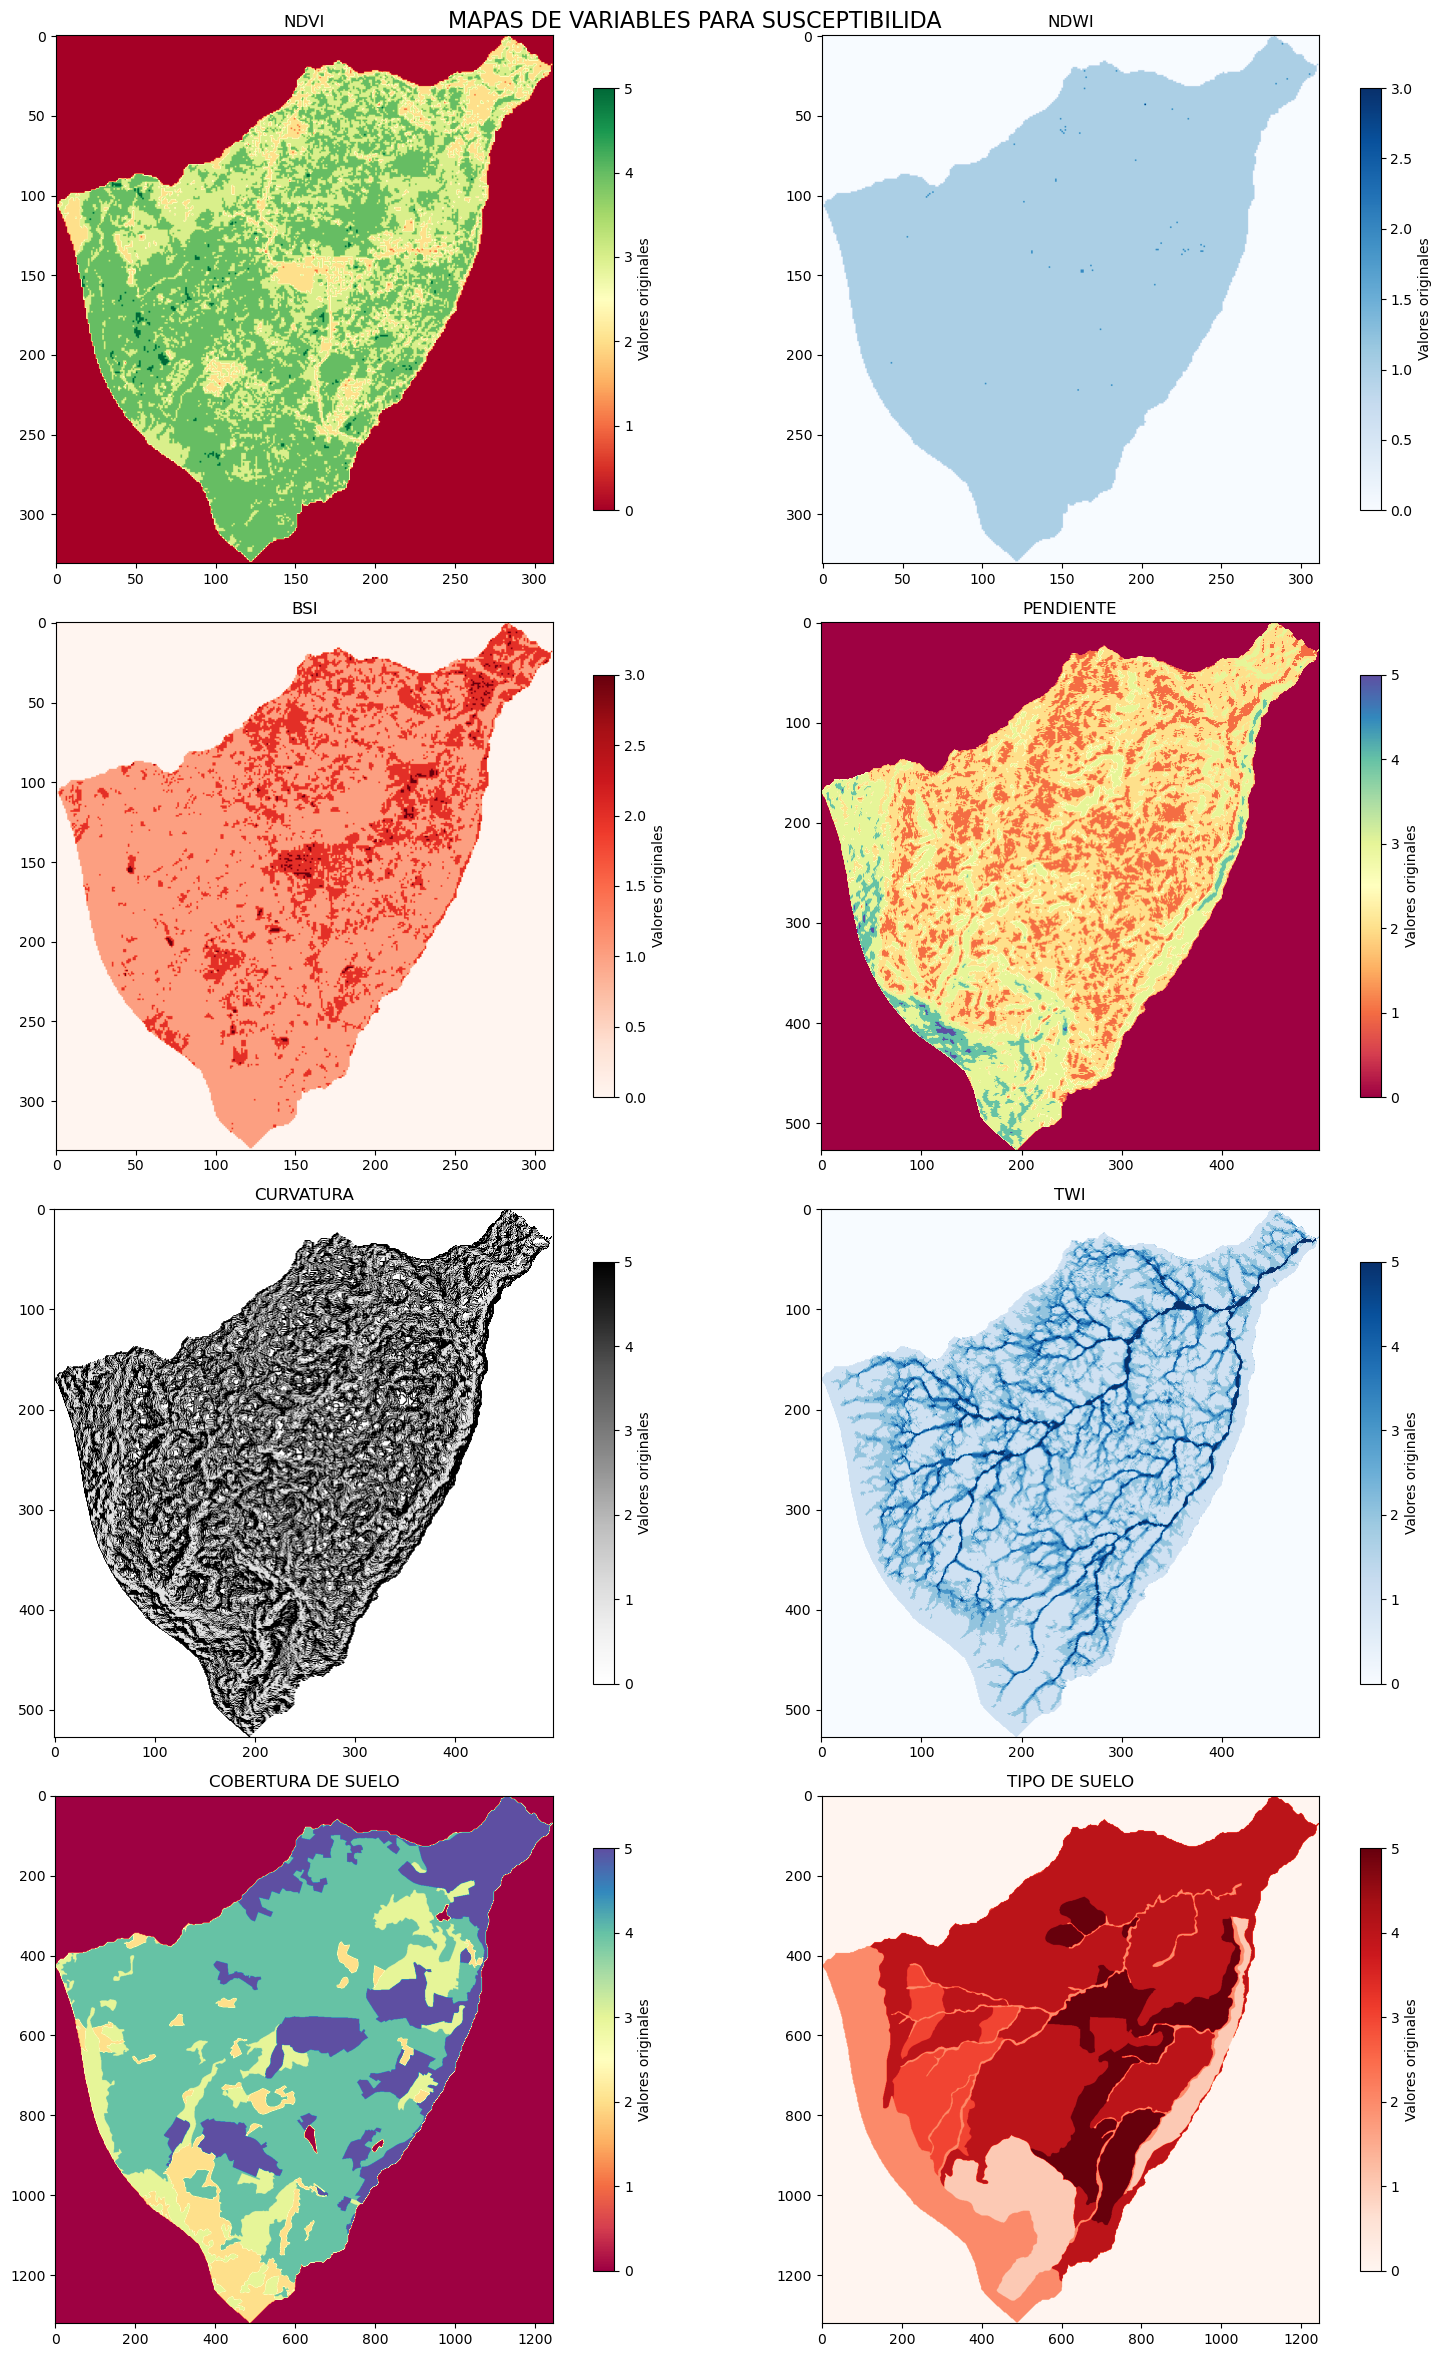

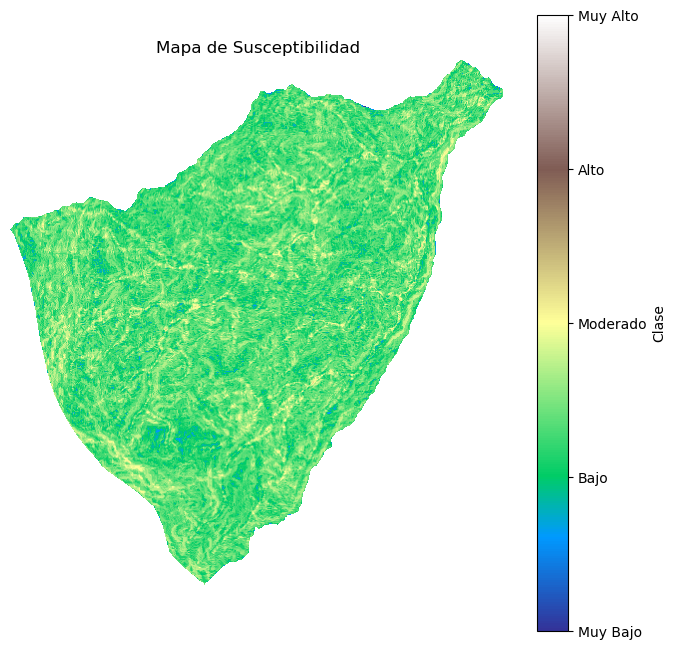

NDVI_recortado → C:\Users\GAMER\ESPECIALIZACION\PROGRAMACION GEO\TRABAJO FINAL\RESULTADOS\NDVI_recortado.tif
NDWI_recortado → C:\Users\GAMER\ESPECIALIZACION\PROGRAMACION GEO\TRABAJO FINAL\RESULTADOS\NDWI_recortado.tif
BSI_recortado → C:\Users\GAMER\ESPECIALIZACION\PROGRAMACION GEO\TRABAJO FINAL\RESULTADOS\BSI_recortado.tif
pendiente_recortado → C:\Users\GAMER\ESPECIALIZACION\PROGRAMACION GEO\TRABAJO FINAL\RESULTADOS\pendiente_recortado.tif
curvatura_recortado → C:\Users\GAMER\ESPECIALIZACION\PROGRAMACION GEO\TRABAJO FINAL\RESULTADOS\curvatura_recortado.tif
TWI_recortado → C:\Users\GAMER\ESPECIALIZACION\PROGRAMACION GEO\TRABAJO FINAL\RESULTADOS\twi_recortado.tif
cobertura_recortado → C:\Users\GAMER\ESPECIALIZACION\PROGRAMACION GEO\TRABAJO FINAL\RESULTADOS\cobertura_recortado.tif
tipo_recortado → C:\Users\GAMER\ESPECIALIZACION\PROGRAMACION GEO\TRABAJO FINAL\RESULTADOS\tipo_suelo_recortado.tif
NDVI_reclasificado → C:\Users\GAMER\ESPECIALIZACION\PROGRAMACION GEO\TRABAJO FINAL\RESULTADOS\nd

In [158]:
# 1) Define un diccionario con las rutas a tus bandas Sentinel-2
band_paths = {
    "Red":   r"C:\Users\GAMER\ESPECIALIZACION\PROGRAMACION GEO\TRABAJO FINAL\DATOS\T17MPR_20220814T153619_B04_20m.tif",
    "NIR":   r"C:\Users\GAMER\ESPECIALIZACION\PROGRAMACION GEO\TRABAJO FINAL\DATOS\T17MPR_20220814T153619_B8A_20m.tif",
    "Green": r"C:\Users\GAMER\ESPECIALIZACION\PROGRAMACION GEO\TRABAJO FINAL\DATOS\T17MPR_20220814T153619_B03_20m.tif",
    "SWIR":  r"C:\Users\GAMER\ESPECIALIZACION\PROGRAMACION GEO\TRABAJO FINAL\DATOS\T17MPR_20220814T153619_B11_20m.tif",
    "Blue":  r"C:\Users\GAMER\ESPECIALIZACION\PROGRAMACION GEO\TRABAJO FINAL\DATOS\T17MPR_20220814T153619_B02_20m.tif"  # necesario para el cálculo de BSI
}

# 2) Rutas a los rásteres de pendiente, curvatura y TWI (ya generados previamente)
raster_pendiente  = r"C:\Users\GAMER\ESPECIALIZACION\PROGRAMACION GEO\TRABAJO FINAL\DATOS\PENDIENTE_MICRO_CUENCA_ESTUDIO_GRADOS.tif"
raster_curvatura  = r"C:\Users\GAMER\ESPECIALIZACION\PROGRAMACION GEO\TRABAJO FINAL\DATOS\Profile_Curvature.tif"
raster_twi        = r"C:\Users\GAMER\ESPECIALIZACION\PROGRAMACION GEO\TRABAJO FINAL\DATOS\Topographic_Wetness_Index.tif"

# 3) Rutas a los rásteres de cobertura de suelo y tipo de suelo (de tu geoportal)
raster_cobertura  = r"C:\Users\GAMER\ESPECIALIZACION\PROGRAMACION GEO\TRABAJO FINAL\DATOS\COBERTURA_TIERRA_CUENCA.tif"
raster_tipo       = r"C:\Users\GAMER\ESPECIALIZACION\PROGRAMACION GEO\TRABAJO FINAL\DATOS\TEXTURA_CUENCA.tif"

# 4) Ruta al shapefile (o GeoJSON) de tu área de estudio (la microcuenca)
area_estudio_shp = r"C:\Users\GAMER\ESPECIALIZACION\PROGRAMACION GEO\TRABAJO FINAL\SHAPE\CUENCA_ESTUDIO.geojson"

# 5) Carpeta de salida donde se guardarán TODOS los TIFF generados
output_folder = r"C:\Users\GAMER\ESPECIALIZACION\PROGRAMACION GEO\TRABAJO FINAL\RESULTADOS"

# 6) Diccionario con los pesos de cada variable (debe coincidir con las llaves usadas dentro de la función)
pesos = {
    "pendiente": 0.289,
    "curvatura": 0.080,
    "twi":       0.181,
    "ndvi":      0.129,
    "ndwi":      0.102,
    "bsi":       0.066,
    "cobertura": 0.059,
    "tipo_suelo": 0.085
}

# 7) Ahora sí, llamas a la función y guardas el resultado en un diccionario:
resultados = susceptibilidad(
    band_paths,
    raster_pendiente,
    raster_curvatura,
    raster_twi,
    raster_cobertura,
    raster_tipo,
    area_estudio_shp,
    output_folder,
    pesos
)

# 8) Imprime en pantalla las rutas de todos los productos generados
for clave, ruta in resultados.items():
    print(f"{clave} → {ruta}")
